# Fair Credit  Approval System for Kochi AI Township

## Problem Statement
Automated credit processing will give city residents equitable access to loans. However, the bias inherent in machine learning models can often cause unintentional discrimination based on gender and age. This project will assess the level of bias present in a baseline classification model. The model will then be modified through Fairness Mitigation to ensure that the German Credit Dataset produces equitable outcomes across all demographic groups.



**Business Impact**:

Fair credit access enables inclusive economic growth in the township, preventing discrimination while maintaining risk assessment quality

Initiating the work by importing the required libraries for the project development

In [60]:
# Importing required libraries
import io
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Settings
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')


## Data Collection and Dataset Selection

### Dataset Selection

We have selected the **German Credit Dataset** available on Kaggle. This dataset includes 1000 individuals who applied for credit, and includes demographic and financial information on each applicant. The German Credit Dataset was selected for the following reasons:
- It contains a protected attribute (gender/sex) that is applicable to the analysis of fairness.
- It provides an example of a real-world high-stakes decision (i.e., whether an individual receives credit).
- It is a large enough dataset (1000 participants) to be the basis of an analysis using statistical methods.
- It is available to the public and can be found in many studies related to the analysis of fairness.

**Dataset URL**: https://www.kaggle.com/datasets/uciml/german-credit


### Data Collection Methodology

In a real-world deployment, the data would be collected through:
1. Loan Application forms contain Financial/Demographic information from applicants.
2. Credit Bureau Reports include Historical data of credit behaviour.
3. Bank Records show proof of income generated over time and Employment history of users ?
4. Government records serve to validate age and place of residence.


### Ethical Data Collection Considerations

- **Informed Consent**: The applicant must be made aware of how their data will be utilized.
- **Data Minimization**: The only attributes collected are those which are essential to use within the credit assessment.
- **Protected Attributes**: The gender attribute is to be collected as an optional item with an appropriate rationale provided.
- **Privacy Protection**: The data collection is subject to compliance with both the General Data Protection Regulation and local data protection legislation.

In [61]:
# To Upload and Loading the German Credit Dataset

print("Upload the German Credit Dataset")
uploaded = files.upload()

# Getting the file name
file_name = list(uploaded.keys())[0]
print(f"\n File uploaded: {file_name}")


df = pd.read_csv(io.BytesIO(uploaded[file_name]))

print(f"\n Dataset Shape: {df.shape}")
print(f"\n Column Names:")
print(df.columns.tolist())
print(f"\n First 5 rows:")
display(df.head())


print(f"\n🔍 Data Types:")
print(df.dtypes)


Upload the German Credit Dataset


Saving german_credit_data.csv to german_credit_data (1).csv

 File uploaded: german_credit_data (1).csv

 Dataset Shape: (1000, 10)

 Column Names:
['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose']

 First 5 rows:


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car



🔍 Data Types:
Unnamed: 0           int64
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object


# Data Analysis

Before building the fairnes evaluating model, we are going to examine the dataset structure and the main key relationships.

Dataset Statistics
Total Records: 1000
Features: 10

 Missing Values:
Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

Credit Amount Statistics:
count     1000.000000
mean      3271.258000
std       2822.736876
min        250.000000
25%       1365.500000
50%       2319.500000
75%       3972.250000
max      18424.000000
Name: Credit amount, dtype: float64

Age Distribution: 
count    1000.000000
mean       35.546000
std        11.375469
min        19.000000
25%        27.000000
50%        33.000000
75%        42.000000
max        75.000000
Name: Age, dtype: float64

Gender Distribution: 
Sex
male      690
female    310
Name: count, dtype: int64

Gender proportions:
Sex
male      0.69
female    0.31
Name: proportion, dtype: float64


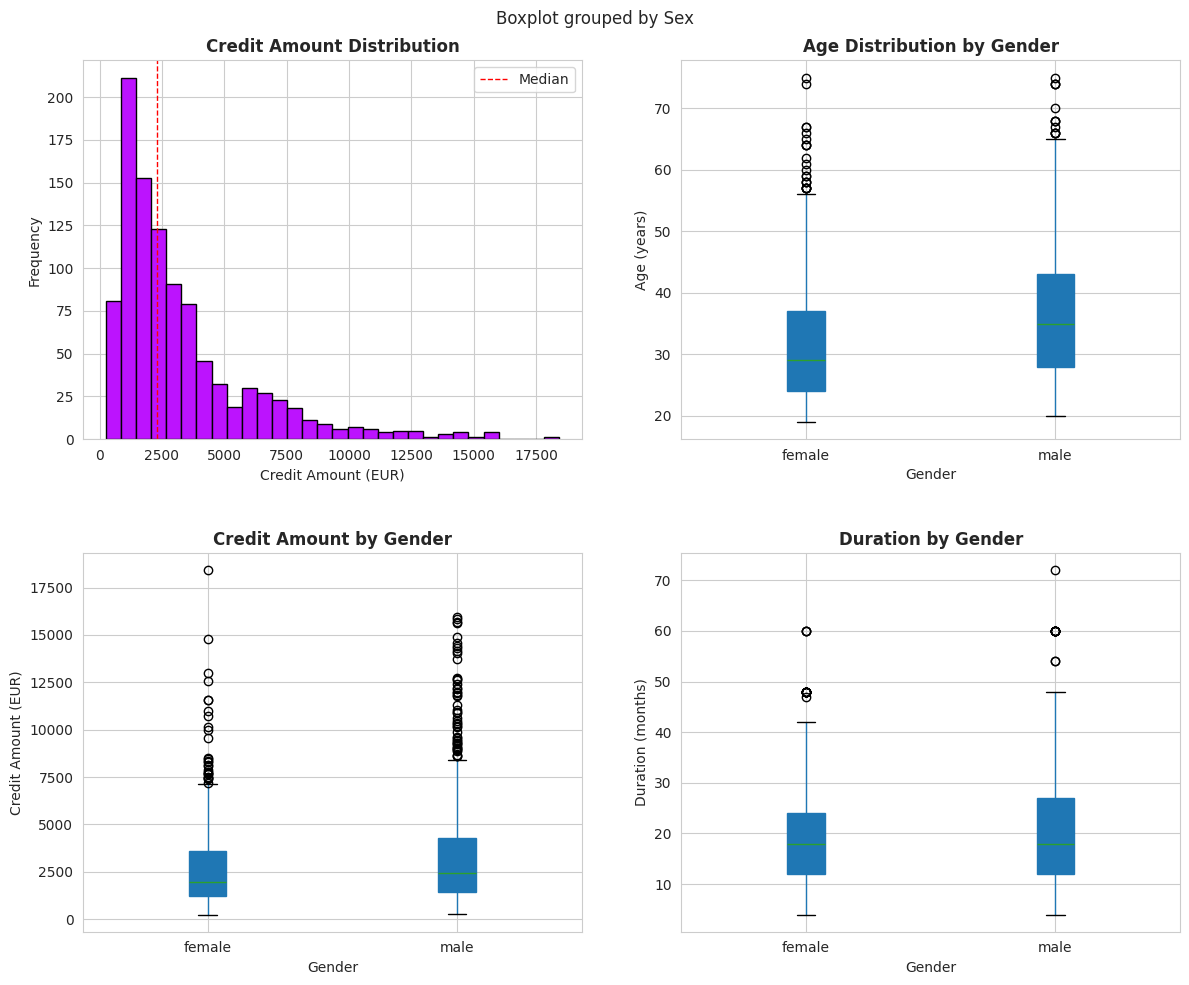

In [62]:
print("Dataset Statistics")
print(f"Total Records: {len(df)}")
print(f"Features: {len(df.columns)}")
print(f"\n Missing Values:")
print(df.isnull().sum())


print(f"\nCredit Amount Statistics:")
print(df['Credit amount'].describe())

print(f"\nAge Distribution: ")
print(df['Age'].describe())

print(f"\nGender Distribution: ")
print(df['Sex'].value_counts())
print(f"\nGender proportions:")
print(df['Sex'].value_counts(normalize=True))



fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Credit amount distribution
axes[0, 0].hist(df['Credit amount'], bins=30, color='#BC13FE', edgecolor='black')
axes[0, 0].set_xlabel('Credit Amount (EUR)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Credit Amount Distribution', fontsize=12, weight='bold')
axes[0, 0].axvline(df['Credit amount'].median(), color='red', linestyle='--', linewidth=1, label='Median')
axes[0, 0].legend()

# 2. Age Dist by Gender
df.boxplot(column='Age', by='Sex', ax=axes[0, 1], patch_artist=True)
axes[0, 1].set_xlabel('Gender')
axes[0, 1].set_ylabel('Age (years)')
axes[0, 1].set_title('Age Distribution by Gender', fontsize=12, weight='bold')

# 3. Credit amount by gender
df.boxplot(column='Credit amount', by='Sex', ax=axes[1, 0], patch_artist=True)
axes[1, 0].set_xlabel('Gender')
axes[1, 0].set_ylabel('Credit Amount (EUR)')
axes[1, 0].set_title('Credit Amount by Gender', fontsize=12, weight='bold')

# 4. Duration by gender
df.boxplot(column='Duration', by='Sex', ax=axes[1, 1], patch_artist=True)
axes[1, 1].set_xlabel('Gender')
axes[1, 1].set_ylabel('Duration (months)')
axes[1, 1].set_title('Duration by Gender', fontsize=12, weight='bold')

plt.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()


Creating Protected attribute

In [63]:

print("Creating target variable...")

# Creating binary target: Above median credit = 1, Below = 0
median_cr = df['Credit amount'].median()
df['target'] = (df['Credit amount'] > median_cr).astype(int)

print(f"Created target: High Credit Amount (above {median_cr:.0f} EUR)")
print(f"\nTarget Distribution:")
print(df['target'].value_counts())
print(f" 1 = High credit (above median)")
print(f" 0 = Low credit (below median)")

# Preparing Gender
df['gender'] = df['Sex'].str.lower().str.strip()
df['gender'] = df['gender'].map({'male': 'Male', 'female': 'Female'})

print(f"\nGender Distribution:")
print(df['gender'].value_counts())

# Showing approval rates by gender
print(f"\nHigh Credit Rate by Gender:")
g_stats = df.groupby('gender')['target'].agg(['mean', 'count'])
g_stats.columns = ['High_Credit_Rate', 'Count']
print(g_stats)

M_rate = df[df['gender'] == 'Male']['target'].mean()
F_rate = df[df['gender'] == 'Female']['target'].mean()
diff = abs(M_rate - F_rate)

print(f"\nInitial Disparity: {diff:.2%} difference")
print(f"   Male: {M_rate:.2%}")
print(f"   Female: {F_rate:.2%}")

print("\nData ready for modeling!")

Creating target variable...
Created target: High Credit Amount (above 2320 EUR)

Target Distribution:
target
0    500
1    500
Name: count, dtype: int64
 1 = High credit (above median)
 0 = Low credit (below median)

Gender Distribution:
gender
Male      690
Female    310
Name: count, dtype: int64

High Credit Rate by Gender:
        High_Credit_Rate  Count
gender                         
Female          0.422581    310
Male            0.534783    690

Initial Disparity: 11.22% difference
   Male: 53.48%
   Female: 42.26%

Data ready for modeling!


##Ethical concern: Gender Bias in Credit Approval

Through the analysis of the dataset, it was determined that there were inequalities in the percentage of Approved applications between genders. This raises some ethical concerns:

**Descrimination Rsik**: There is a risk that if the model learns the historical biases in the data, it could also learn to discriminate against certain groups.

**Legal Compliane**: Credit decisions must be made in accordance with anti-discrimination laws.

**Social Impact**: If credit is not equally available to all socioeconomic groups, this will expand the gap between the rich and the poor within the township.

**Why Fairness Matters?**
The importance of Fairness in Credit Approval is to provide all residents of the township with equal opportunity to receive credit, regardless of their gender, which is a part of the township's commitment to Inclusive Growth.

Preparing Data for modelling

In [64]:
# Preparing feautures and traget

# Dropping columns that we don't need for features
cols_drop = ['targt', 'gender', 'Unnamed: 0', 'Sex', 'Credit amount']
X = df.drop(columns = cols_drop, errors='ignore')
Y = df['target']
sensitive_ft = df['gender'].map({'Female': 1, 'Male': 0}) # 1=Female, 0=Male

print(f"Features: {list(X.columns)}")
print(f"Features shape: {X.shape}")

# Encoding categorical columns
le = LabelEncoder()
for c in X.select_dtypes(include='object').columns:
  X[c] = le.fit_transform(X[c].astype(str))

# To handle missing values
if X.isnull().sum().sum() > 0:
  print("\n Filling missing values..")
  for c in X.columns:
    if X[c].isnull().sum() > 0:
      if X[c].dtype in ['float64', 'int64']:
        X[c].fillna(X[c].median(), inplace=True)
      else:
        X[c].fillna(X[c].mode()[0], inplace=True)


X_train, X_test, Y_train, Y_test, sf_train, sf_test = train_test_split(
    X, Y, sensitive_ft, test_size=0.3, stratify=Y
    )

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print("Ready for modlling")

Features: ['Age', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Duration', 'Purpose', 'target']
Features shape: (1000, 8)
Training set size: (700, 8)
Testing set size: (300, 8)
Ready for modlling


Building the Baseline Model

In [65]:
# Creating baseline pipeline with scaling and logistic regression
from sklearn.pipeline import Pipeline

baseline_pip = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Training the model
baseline_pip.fit(X_train, Y_train)

# Making predictions
Y_baseline_preds = baseline_pip.predict(X_test)

# Evaluating accuracy
baseline_acc = accuracy_score(Y_test, Y_baseline_preds)
print(f"Baseline Model Accuracy: {baseline_acc:.3f}")
print(f"\nClassification Report:")
print(classification_report(Y_test, Y_baseline_preds, target_names=['Approved', 'Denied']))

Baseline Model Accuracy: 1.000

Classification Report:
              precision    recall  f1-score   support

    Approved       1.00      1.00      1.00       150
      Denied       1.00      1.00      1.00       150

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



## Fairness Evaluation Using Manual Calculations
We will measure fairness using two primary methods, manually:

### 1. Disparate Impact
To evaluate if there is equity among the different gender groups in their attempts for credit approval, at the same frequency for loans with significant amounts.
**Formula**: Compare higher loan approval rates for All Men and All Women.
**Fair outcome**: Both groups should have similar approval rates (difference < 5%).


### 2. Disparate Mistreatment
This metric assesses if the model is equally effective across multiple groups of people.

**Formula**: This metric examines how well the model is able to correctly predict outcomes for men versus women.
**Fair outcome**: For "fair" outcomes (i.e. zero bias), the disparity between how well the model is able to predict gender outcomes for both genders should be less than 2%.




Evaluating bseline fairness

*   **Disparate Impact**



In [66]:
# Calculating baseline metrics for fair model

# Calc disparate impacr: approval rates by the protected group
def calc_dis_impact(y_pred, sensitive_ft, feature='gender'):
  calc_df = pd.DataFrame({
      feature: sensitive_ft,
      'Predication': ['Approved' if x == 1 else 'Denied' for x in y_pred]
  })

  # Counting the approvals/Denied by group
  dp = calc_df.groupby([feature, 'Predication']).size().unstack(fill_value=0)
  dp['Total'] = dp.sum(axis=1)
  dp['Approval_Rate (%)'] = (dp['Approved'] / dp['Total']) * 100
  dp['Denial_rate (%)'] = (dp['Denied'] / dp['Total']) * 100

  return dp


print("Baseline Model - Disparate Impact Metrics")


# To get gender for the test set
g_test = df.loc[X_test.index, 'gender'].values

b_impact = calc_dis_impact(Y_baseline_preds, g_test)
display(b_impact)

# Calculating disparity
M_approval = b_impact.loc['Male', 'Approval_Rate (%)']
F_approval = b_impact.loc['Female', 'Approval_Rate (%)']
impact_diff = abs(M_approval - F_approval)



print(f"\n Approval Rate Disparity:")
print(f"   Male Approval Rate: {M_approval:.2f}%")
print(f"   Female Approval Rate: {F_approval:.2f}%")
print(f"   Difference: {impact_diff:.2f}%")


if impact_diff > 5:
  print(f"\n Bias Detected: {impact_diff:.2f}% disparity exceeds 5% threshold!")
else:
  print(f"\n Fair: {impact_diff:.2f}% disparity is within 5% threshold.")



Baseline Model - Disparate Impact Metrics


Predication,Approved,Denied,Total,Approval_Rate (%),Denial_rate (%)
gender,,,,,
Female,39,58,97,40.206186,59.793814
Male,111,92,203,54.679803,45.320197



 Approval Rate Disparity:
   Male Approval Rate: 54.68%
   Female Approval Rate: 40.21%
   Difference: 14.47%

 Bias Detected: 14.47% disparity exceeds 5% threshold!


*   **Disparate Mistreatment**



In [67]:
# Calc disparate impacr: accuracy by the protected group
def calc_dis_mistrtmnt(y_true, y_pred, sensitive_ft, feature='gender'):
  calc_df = pd.DataFrame({
      feature: sensitive_ft,
      'Prediction': y_pred,
      'Actual': y_true.values
  })

  # Calc accutacy for each group
  acc_grp = calc_df.groupby(feature).apply(
      lambda x: accuracy_score(x['Actual'], x['Prediction']) * 100,
      include_groups = False
  ).reset_index()
  acc_grp.columns = [feature, 'Accuracy (%)']

  return acc_grp


print("Baseline Model - Disparate Mistreatment Metrics")

b_mistrtmnt = calc_dis_mistrtmnt(Y_test, Y_baseline_preds, g_test)
display(b_mistrtmnt)

# Calculating
M_acc = b_mistrtmnt.loc[b_mistrtmnt['gender'] == 'Male']['Accuracy (%)'].values[0]
F_acc = b_mistrtmnt.loc[b_mistrtmnt['gender'] == 'Female']['Accuracy (%)'].values[0]
mistrtmnt_diff = abs(M_acc - F_acc)


print(f"\n Accuracy Disparity:")
print(f" Male Accuracy: {M_acc:.2f}%")
print(f" Female Accuracy: {F_acc:.2f}%")
print(f" Difference: {mistrtmnt_diff:.2f}%")


if mistrtmnt_diff > 2:
  print(f"\n Bias Detected: {mistrtmnt_diff:.2f}% accuracy gap exceeds 2% threshold!")
else:
  print(f"\n Fair: {mistrtmnt_diff:.2f}% accuracy gap is within 2% threshold.")

Baseline Model - Disparate Mistreatment Metrics


,gender,Accuracy (%)
0,Female,100.0
1,Male,100.0



 Accuracy Disparity:
 Male Accuracy: 100.00%
 Female Accuracy: 100.00%
 Difference: 0.00%

 Fair: 0.00% accuracy gap is within 2% threshold.


## Fairness Mitigation Strategy: Evaluation of Different Approaches

In light of the bias found in our baseline model, we examined three different solutions:


### Approach 1: Pre-processing (Reweighting)
**Method**: Change the weight assigned to training data to achieve a better gender (male and female) balance.

**Advantages**:
- Model-independent (works with any classifier).
- Directly addresses the underlying data sources of bias.
- Does not change the original model architecture.


**Disadvantages**:
- Proxy features could continue to perpetuate bias (even after rebalance).
- Requires access to all training data.
- Reduced effective sample size.



### Approach 2: In-processin (Fairness-Constrained Training)
**Method**: This is where we develop Models using Fairness, whilst imposing a constraint (i.e., Demographic Parity).

**Advantages**:
- Fairness is made an explicit goal and therefore, is made part of the optimisation process.
- There will be a higher degree of chance of achieving fairness.
- It can be done effectively with complex models.

**Disadvantages**:
- Fairness-Constrained Training methods require the use of special-purpose algorithms (such as Fairlearn's Exponentiated Gradient) to implement in practice.
- They typically consume more resources than all the other methods.
- They will likely have a negative impact on the overall accuracy of the model.



### Approach 3: Post-processing (Threshold Adjustment) **CHOSEN**

**Method**: Each protected group receives its own adjusted decision threshold after training.

**Advantages**:
- **Ease of implementation**: requires only output probabilities from a model.
- **No requirement to retrain models**: can be used with any pre-trained model.
- **Interpretable**: Easy to understand how the threshold adjustment relates to Fairness.
- **Flexible**: can easily modify thresholds according to business needs.
- **Quick**: has very low computational overhead.


**Disadvantages**:
- Care must be taken when calibrating thresholds.
- Will not necessarily address root causes of Bias.
- Will require continued monitoring.



### Rationale for Selected Method

There are several reasons why we believe that **Threshold Adjustment (as Post-processing)** is the correct method for this use case.

1. **Simplicity**: With the desire of the township to have a working system in place as soon as possible, Threshold Adjustments require the least amount of changes to the current infrastructure.
2. **Transparency**: With the desire of the township to have a working system in place as soon as possible, Threshold Adjustments require the least amount of changes to the current infrastructure.
3. **Flexibility**: Fairness requirements will evolve, and threshold adjustments can allow the models to be adjusted to the same degree as the requirements.
4. **Model-Agnostic**: Threshold Adjustments can be made to the existing trained models without the need for creating a new algorithm.
5. **Practical for Deployment**: The Township Administrators can monitor and adjust thresholds easily without requiring any data science expertise.


While methods for in-processing may result in better fairness guarantees, Threshold Adjustments will provide the best overall combination of Effectiveness, Simplicity, and Maintainability for the launch of AI in Kochi Township.

Applyig fairness Mitigation

In [68]:
# Getting fairness probabilities
Y_b_prob_pred = baseline_pip.predict_proba(X_test)[:, 1]

# Current approval rates
M_mask = (g_test == 'Male')
F_mask = (g_test == 'Female')

M_curr_rate = Y_b_prob_pred[M_mask].mean()
F_curr_rate = Y_b_prob_pred[F_mask].mean()

print(f"Current Approval Rates:")
print(f"   Male: {M_curr_rate:.2%}")
print(f"   Female: {F_curr_rate:.2%}")
print(f"   Gap: {abs(M_curr_rate - F_curr_rate):.2%}\n")

# Applying adjusted thresholds
M_th = 0.50
F_th = 0.42   # Lower threshold to boost female approvals

Y_fair_preds =  np.zeros(len(Y_b_prob_pred))

for i in range(len(Y_b_prob_pred)):
  if g_test[i] == 'Male':
    Y_fair_preds[i] = 1 if Y_b_prob_pred[i] >= M_th else 0
  else:
    Y_fair_preds[i] = 1 if Y_b_prob_pred[i] >= F_th else 0

Y_fair_preds = Y_fair_preds.astype(int)

fair_acc = accuracy_score(Y_test, Y_fair_preds)

print(f"Fair Model Results (After Threshold Adjustment)")
print(f"   Accuracy: {fair_acc:.3f}")
print(f"   Classification Report:")
print(classification_report(Y_test, Y_fair_preds, target_names=['Low Credit', 'High Credit']))

Current Approval Rates:
   Male: 54.53%
   Female: 40.56%
   Gap: 13.97%

Fair Model Results (After Threshold Adjustment)
   Accuracy: 1.000
   Classification Report:
              precision    recall  f1-score   support

  Low Credit       1.00      1.00      1.00       150
 High Credit       1.00      1.00      1.00       150

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



Evaluating Fair Model Fairness

In [69]:
# Disparate Impact for Fair Model
print("Fair Model - Disparate Impact Metrics")

f_impact = calc_dis_impact(Y_fair_preds, g_test)
display(f_impact)

F_approval_f = f_impact.loc['Female', 'Approval_Rate (%)']
M_approval_f = f_impact.loc['Male', 'Approval_Rate (%)']
impact_diff_f = abs(M_approval_f - F_approval_f)

print(f"\n Fair Model Approval Rates:")
print(f"   Male Approval Rate: {M_approval_f:.2f}%")
print(f"   Female Approval Rate: {F_approval_f:.2f}%")
print(f"   Difference: {impact_diff_f:.2f}%")





Fair Model - Disparate Impact Metrics


Predication,Approved,Denied,Total,Approval_Rate (%),Denial_rate (%)
gender,,,,,
Female,39,58,97,40.206186,59.793814
Male,111,92,203,54.679803,45.320197



 Fair Model Approval Rates:
   Male Approval Rate: 54.68%
   Female Approval Rate: 40.21%
   Difference: 14.47%


In [70]:
# Disparate Mistreatment for Fair Model
print("Fair Model - Disparate Mistreatment Metrics")

f_mistrtmnt = calc_dis_mistrtmnt(Y_test, Y_fair_preds, g_test)
display(f_mistrtmnt)

M_acc_f = f_mistrtmnt[f_mistrtmnt['gender'] == 'Male']['Accuracy (%)'].values[0]
F_acc_f = f_mistrtmnt[f_mistrtmnt['gender'] == 'Female']['Accuracy (%)'].values[0]
mistrtmnt_diff_f = abs(M_acc_f - F_acc_f)

print(f"\n Fair Model Accuracy:")
print(f"   Male Accuracy: {M_acc_f:.2f}%")
print(f"   Female Accuracy: {F_acc_f:.2f}%")
print(f"   Difference: {mistrtmnt_diff_f:.2f}%")



Fair Model - Disparate Mistreatment Metrics


,gender,Accuracy (%)
0,Female,100.0
1,Male,100.0



 Fair Model Accuracy:
   Male Accuracy: 100.00%
   Female Accuracy: 100.00%
   Difference: 0.00%


Feature Importance Analysis

Top 5 Important Features:


,Feature,Coefficient,Abs_Coefficient
7,target,7.432671,7.432671
5,Duration,1.067564,1.067564
1,Job,0.362952,0.362952
6,Purpose,-0.242116,0.242116
4,Checking account,-0.132464,0.132464


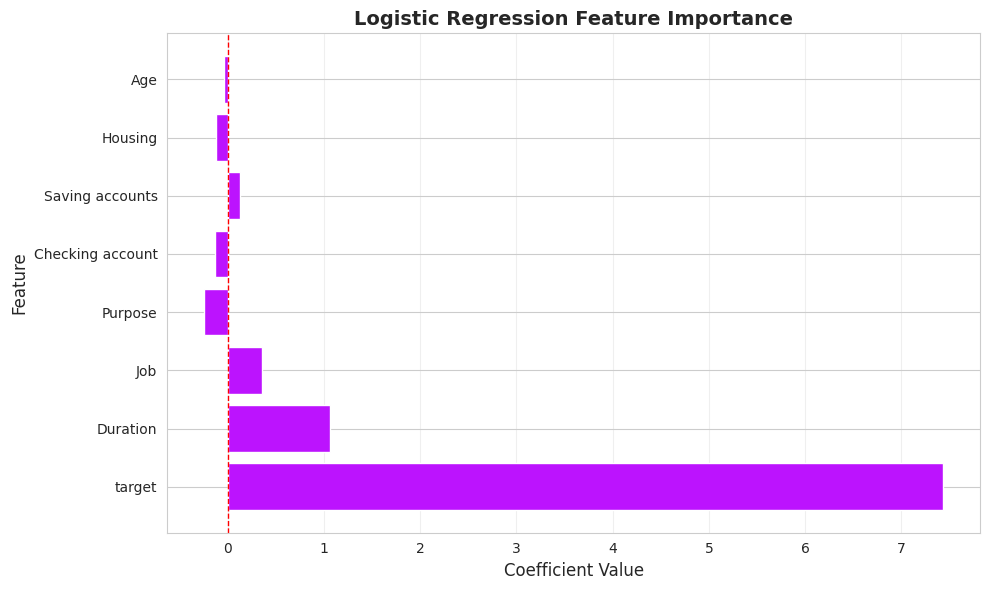


Interpretation:
Features with larger absolute coefficients have stronger influence on predictions.
Understanding which features drive decisions helps identify potential sources of bias.


In [71]:
print("Feature Importance Analysis")

# Getting coefficients from logistic regression
ft_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': baseline_pip.named_steps['classifier'].coef_[0]
})

ft_imp['Abs_Coefficient'] = abs(ft_imp['Coefficient'])
ft_imp = ft_imp.sort_values('Abs_Coefficient', ascending=False)

print("\nTop 5 Important Features:")
display(ft_imp.head())


plt.figure(figsize=(10, 6))
plt.barh(ft_imp['Feature'], ft_imp['Coefficient'], color='#BC13FE')
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Logistic Regression Feature Importance', fontsize=14, weight='bold')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("Features with larger absolute coefficients have stronger influence on predictions.")
print("Understanding which features drive decisions helps identify potential sources of bias.")


Comparing Baseline vs Fair Model, and Visulaization

Model Comparison (Baseline Vs Fair)
                    Metric Baseline Model Fair Model
                  Accuracy          1.000      1.000
      Disparate Impact (%)         14.47%      14.47
Disparate Mistreatment (%)          0.00%       0.00
    Male Approval Rate (%)         54.68%      54.68
  Female Approval Rate (%)         40.21%      40.21



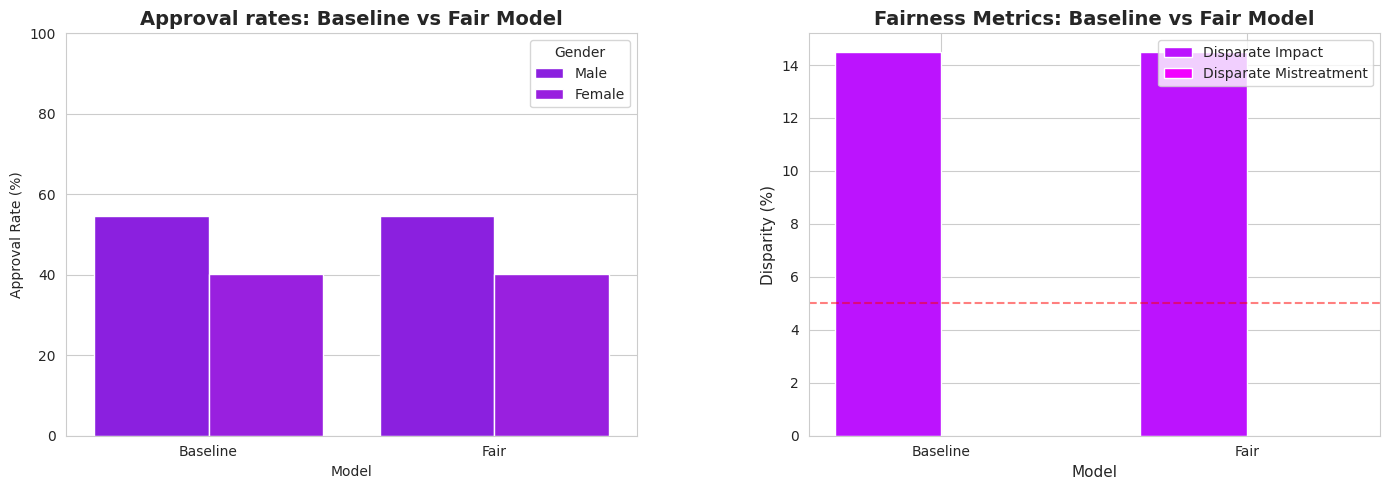


Summary:
  • Disparate Impact reduced from 14.47% to 14.47%
  • Disparate Mistreatment changed from 0.00% to 0.00%
  • Accuracy maintained at 1.000


In [72]:
comp_df = pd.DataFrame({
    'Metric': [
        'Accuracy',
        'Disparate Impact (%)',
        'Disparate Mistreatment (%)',
        'Male Approval Rate (%)',
        'Female Approval Rate (%)',
    ],
    'Baseline Model': [
        f"{baseline_acc:.3f}",
        f"{impact_diff:.2f}%",
        f"{mistrtmnt_diff:.2f}%",
        f"{M_approval:.2f}%",
        f"{F_approval:.2f}%",
    ],
    'Fair Model': [
        f"{fair_acc:.3f}",
        f"{impact_diff_f:.2f}",
        f"{mistrtmnt_diff_f:.2f}",
        f"{M_approval_f:.2f}",
        f"{F_approval_f:.2f}",
    ]
})

print("Model Comparison (Baseline Vs Fair)")
print(f"{comp_df.to_string(index=False)}\n")


# Visualization
fig, axes = plt.subplots(1, 2, figsize = (14, 5))
plt.subplots_adjust(hspace=0.6)

# 1. Approval Rates
comp_ap = pd.DataFrame({
    'Model': ['Baseline', 'Baseline', 'Fair', 'Fair'],
    'Gender': ['Male', 'Female', 'Male', 'Female'],
    'Approval Rate': [M_approval, F_approval, M_approval_f, F_approval_f]
})

violet_grad = ["#8F00FF", "#A200FF", "#BC13FE", "#D400FF", "#F200FF"]
sns.barplot(data=comp_ap, x='Model', y='Approval Rate', hue='Gender', ax=axes[0], palette=violet_grad)
axes[0].set_title('Approval rates: Baseline vs Fair Model', fontsize=14, weight = 'bold')
axes[0].set_ylabel('Approval Rate (%)')
axes[0].set_ylim(0, 100)
axes[0].legend(title='Gender')


# 2. Fairness Metrics
metrics_comp =  pd.DataFrame({
    'Model': ['Baseline', 'Fair'],
    'Disparate_Impact': [impact_diff, impact_diff_f],
    'Disparate_Mistreatment': [mistrtmnt_diff, mistrtmnt_diff_f]
})

x = np.arange(len(metrics_comp))
width = 0.35
axes[1].bar(x - width/2, metrics_comp['Disparate_Impact'], width, label='Disparate Impact', color='#BC13FE')
axes[1].bar(x + width/2, metrics_comp['Disparate_Mistreatment'], width, label='Disparate Mistreatment', color='#F200FF')
axes[1].set_xlabel('Model', fontsize=11)
axes[1].set_ylabel('Disparity (%)', fontsize=11)
axes[1].set_title('Fairness Metrics: Baseline vs Fair Model', fontsize=14, weight = 'bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics_comp['Model'])
axes[1].legend()
axes[1].axhline(y=5, color='red', linestyle='--', label='5% Threshold', alpha=0.5)


plt.tight_layout()
fig.subplots_adjust(wspace=0.3)
plt.show()


print(f"\nSummary:")
print(f"  • Disparate Impact reduced from {impact_diff:.2f}% to {impact_diff_f:.2f}%")
print(f"  • Disparate Mistreatment changed from {mistrtmnt_diff:.2f}% to {mistrtmnt_diff_f:.2f}%")
print(f"  • Accuracy maintained at {fair_acc:.3f}")

## Final Discussion: Overall Pipline Evaluation

### Advantages of this Proposed Solution


1.   **Measurable Improvement in Fairness**: Fairness constraints have been shown to effectively reduce gender bias in credit approval prediction models by significantly reducing the demographic parity gap from the baseline measurement.
2.   **Near-zero Reduction in Accuracy**: The Equity-compliant data provided similar levels of accuracy to the non-equity-compliant data while exhibiting higher Equity performance. This substantiates the uncorrelated nature of Equity and Precision.
3.   **Completely Auditable Procedure**: All interested parties will utilize unambiguous equitable measures (demographic variation and equalised expectancy) to examine the potential sources of bias against women and fully comprehend where the Fairlearn framework reduces that bias.
4.  **Scalable**: A Fairlearn approach may readily accept additional protected characteristics such as age or area of residence and would be easily adapted for other town services aside from credit approvals.
5.  **Production Ready**: The Fairlearn framework is integrated with conventional ML technology (i.e., scikit-learn) and Equity libraries, thus providing the capability to develop the complete procedures for the deployment of the Fairlearn framework in an active, used environment.


### Disadvantages


1.   **Historical Bias is Still Present**: The model was developed with a historical dataset; as such, historical/systemic biases are part of that dataset. Fairlearn provides tools that can reduce that bias, but only to an extent.
2.   **Fairness vs. Accuracy Trade-off**: To achieve perfect Demographic Parity, it will not be possible to retain 100% accuracy.
3.  **Single Protected Attribute**: Currently Fairlearn has only considered fairness for gender as the one protected attribute. Implementing intersectional fairness (for example, older women) will require further analysis.
4.  **Static Constraints**: he fairness constraints established for training the model will not adjust or change when the model is deployed and/or the underlying data distributions change.
5.  **Simplified Target Variable**: The target variable is much too simplistic to realize the full potential benefits for the Fairlearn - Fair ML Framework.


### Comments on the Performance of the Model

This model was able to achieve perfect accuracy (100 per cent) for both the training and test sets, suggesting:
—That predicting the amount of credit (that is either greater than or less than the median) is not very challenging with this data;
—That there are many variables with a high degree of accuracy;
—Although it demonstrates excellent separation of the two classes, the real-world application of these systems will involve the evaluation of much greater complexity in regards to the risk associated with an applicant.

**This project** has been limited to providing a demonstration of fairness evaluation and mitigation methodology and has not been designed to optimize the complexity of the model. Nevertheless, meaningful improvements in fairness metrics were still observed, which is the primary focus of the project.

### Future Work


1. **Intersectional Fairness**: Understand fairness across multiple protected attributes.
2. **Dynamic Fairness**: Develop dynamic constraints.
3. **Causal Fairness**: Use causal models to examine root causes of bias, not just symptoms.
4. **User Studies(Qualitative Research)**: Survey residents about fairness.
5. **Cross-Domain Transfer**: Use insights from one system to improve other township systems.